In [3]:
import numpy as np
import statsmodels.tsa.stattools as ts
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import linregress
import warnings 
from arch import arch_model

Some ideas:
- statistical arbitrage
-

Resources:
- https://quantocracy.com/
- https://arxiv.org/ftp/arxiv/papers/1601/1601.00991.pdf


In [4]:
def download_data(stock, start, end):
    try:
        ticker = yf.download(stock, start, end)
        return pd.DataFrame({'price': ticker['Adj Close']})
    except Exception as e:
        print(f"Error downloading {stock}: {e}")
        return pd.DataFrame()

warnings.filterwarnings("ignore")

[*********************100%***********************]  2 of 2 completed


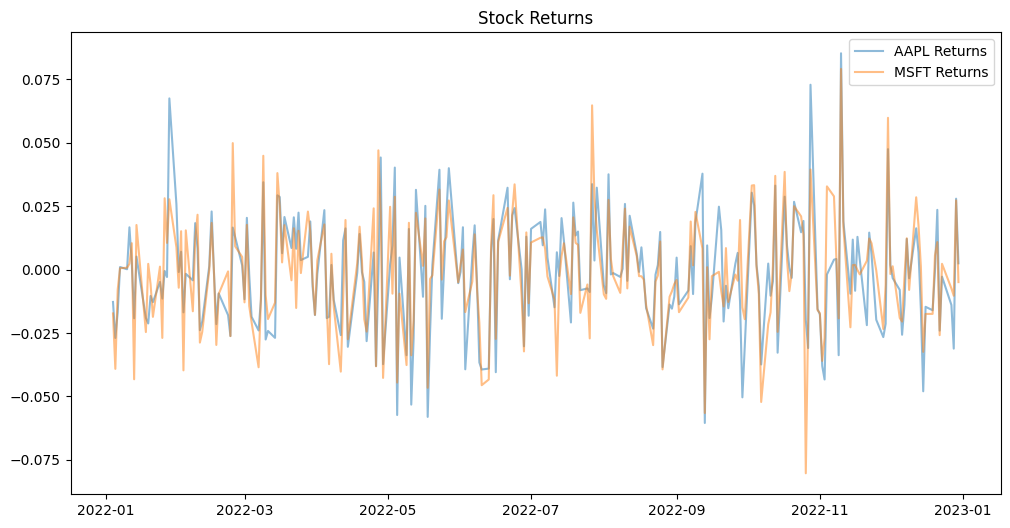

Predicted Volatility AAPL: 0.000495630167185551
Predicted Volatility MSFT: 0.0005118628650893609


In [5]:
# Step 1: Collect Data
symbols = ['AAPL', 'MSFT']
data = yf.download(symbols, start='2022-01-01', end='2023-01-01')['Adj Close']
returns = np.log(data / data.shift(1)).dropna()

# Step 2: Fit Diagonal BEKK GARCH Model for each asset
# Fit GARCH model for each return series
aapl_model = arch_model(returns['AAPL'], vol='Garch', p=1, q=1, dist='normal')
msft_model = arch_model(returns['MSFT'], vol='Garch', p=1, q=1, dist='normal')

aapl_fit = aapl_model.fit(disp='off')
msft_fit = msft_model.fit(disp='off')

# Step 3: Forecast Volatility
aapl_forecast = aapl_fit.forecast(horizon=5)
msft_forecast = msft_fit.forecast(horizon=5)

predicted_volatility_aapl = aapl_forecast.variance.values[-1, 0]  # Get scalar value for AAPL
predicted_volatility_msft = msft_forecast.variance.values[-1, 0]  # Get scalar value for MSFT

# Step 4: Trading Strategy
# Example Strategy: Buy when predicted volatility is low
threshold_aapl = np.percentile(aapl_forecast.variance.values[-1], 25)  # Buy/Sell threshold
threshold_msft = np.percentile(msft_forecast.variance.values[-1], 25)

signals_aapl = (predicted_volatility_aapl < threshold_aapl).astype(int)  # 1 for buy, 0 for hold
signals_msft = (predicted_volatility_msft < threshold_msft).astype(int)

# Step 5: Visualization
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['AAPL'], label='AAPL Returns', alpha=0.5)
plt.plot(returns.index, returns['MSFT'], label='MSFT Returns', alpha=0.5)
plt.title('Stock Returns')
plt.legend()
plt.show()

print('Predicted Volatility AAPL:', predicted_volatility_aapl)
print('Predicted Volatility MSFT:', predicted_volatility_msft)

In [6]:
def download_data(stock, start, end):
    stock_data = {}
    ticker = yf.download(stock, start,end, progress=False)
    stock_data['price'] = ticker['Adj Close']
    return pd.DataFrame(stock_data)

def filter_non_null_rows(df1, df2):
    # Create a mask for rows that are not null in both DataFrames
    mask = df1.notnull() & df2.notnull() 
    # Filter both DataFrames using the mask
    filtered_df1 = df1[mask.all(axis=1)]
    filtered_df2 = df2[mask.all(axis=1)]
    return filtered_df1, filtered_df2

tick_list = ['EUR=X','GBP=X', 'JPY=X', 'CNY=X', 'HKD=X', 'SGD=X', 'INR=X', 'MXN=X', 'PHP=X', 'IDR=X', 'THB=X', 'MYR=X', 'ZAR=X', 'RUB=X']

if __name__ == '__main__':
    start_date = datetime.datetime(2012,1,1)
    end_date = datetime.datetime(2023,12,31)

    for i in tick_list:
        for j in tick_list:
            if i != j:
                pair1, pair2 = filter_non_null_rows(download_data(i, start_date, end_date), download_data(j, start_date, end_date))
                unitone = ts.adfuller(pair1)
                unittwo = ts.adfuller(pair2)
                if unitone[1] > 0.05 and unittwo[1] > 0.05:
                    result = linregress(pair1.values[:,0], pair2.values[:,0]) 
                    residuals = pair1 - result.slope * pair2 
                    adf = ts.adfuller(residuals)
                    if adf[1] < 0.1: #Testing for which pairs are critical in 1% significance level
                        print(i, j, adf)
                else:
                    print(i, unitone[1])
                    print(j, unittwo[1])

    #for i in tick_list:
        #pair1 = download_data(i, start_date, end_date).dropna()
        #adf = ts.adfuller(pair1)
        #if adf[1] < 0.01: #Testing for which pairs are critical in 1% significance level
            #print(i, adf)    

JPY=X RUB=X (np.float64(-2.9097583337057062), np.float64(0.04422494695803587), 26, 3099, {'1%': np.float64(-3.4324618828192937), '5%': np.float64(-2.862473097907828), '10%': np.float64(-2.567266710687779)}, np.float64(14356.370700571417))


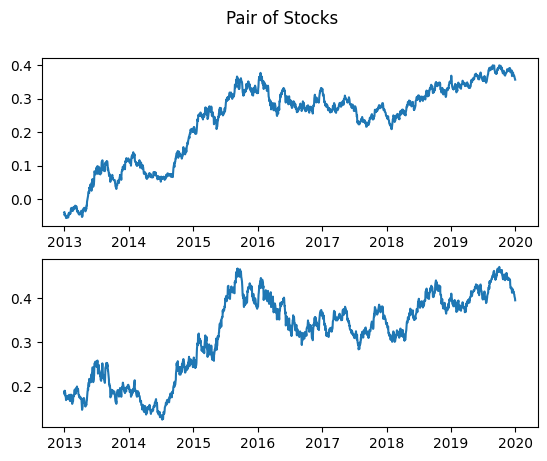

               price
Date                
2013-01-01 -0.039126
2013-01-02 -0.038419
2013-01-03 -0.048119
2013-01-04 -0.044307
2013-01-07 -0.048350
...              ...
2019-12-25  0.367902
2019-12-26  0.367486
2019-12-27  0.364365
2019-12-30  0.359107
2019-12-31  0.356475

[1822 rows x 1 columns]
LinregressResult(slope=np.float64(0.7447730943120859), intercept=np.float64(0.1442823509268797), rvalue=np.float64(0.9446487484966776), pvalue=np.float64(0.0), stderr=np.float64(0.006063204802197308), intercept_stderr=np.float64(0.0015853907927435723))
(np.float64(-2.8914710409373754), np.float64(0.04634882678730658), 0, 1821, {'1%': np.float64(-3.4339461240890983), '5%': np.float64(-2.8631284882870625), '10%': np.float64(-2.5676156576381293)}, np.float64(-14821.46147528779))


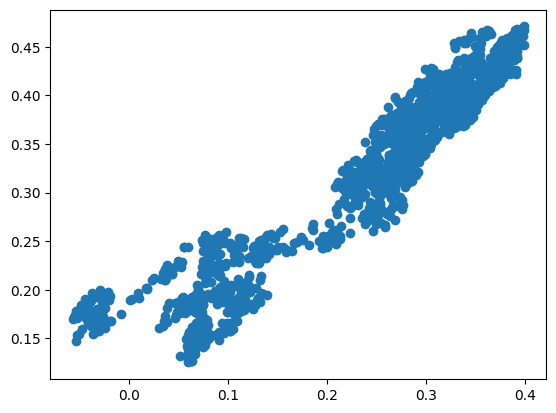

In [19]:
def plot_pairs(data1, data2):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle("Pair of Stocks")
    ax1.plot(data1)
    ax2.plot(data2)
    plt.show()

if __name__ == '__main__':
    start_date = datetime.datetime(2013, 1,1)
    end_date = datetime.datetime(2020,1,1)

    pair1 = download_data('AUD=X', start_date, end_date).apply(np.log)
    pair2 = download_data('NZD=X', start_date, end_date).apply(np.log)

    plot_pairs(pair1, pair2)
    plt.scatter(pair1.values, pair2.values)

    result = linregress(pair1.values[:,0], pair2.values[:,0])
    residuals = pair1 - result.slope * pair2 
    adf = ts.adfuller(residuals) 
    print(result)
    print(adf)


    

In [8]:
def filter_non_null_rows(dfs, tickers):
    # Create a mask for rows that are not null in all DataFrames
    mask = pd.concat([df.notnull() for df in dfs], axis=1).all(axis=1)
    
    # Filter each DataFrame using the mask
    filtered_dfs = [df[mask] for df in dfs]
    concatenated_df = pd.concat(filtered_dfs, axis=1)
    concatenated_df.columns = tickers
    return concatenated_df

def johansen(start_date, end_date, ticker_sublist:list):

    master_list = []
    for ticker in ticker_sublist:
        stock_data = download_data(ticker, start_date, end_date)
        master_list.append(stock_data)

    master_df = filter_non_null_rows(master_list, ticker_sublist)
    johansen_test = coint_johansen(master_df, det_order=0, k_ar_diff=1)

    # Print test results
    trace_stat = johansen_test.lr1  # Trace statistic
    crit_values = johansen_test.cvt  # Critical values

    print(f"Johansen Test Results for {ticker_list}:")
    for i in range(len(trace_stat)):
        print(f'Rank {i}: Trace Statistic = {trace_stat[i]:.4f}, Critical Value (95%) = {crit_values[i, 1]:.4f}')

if __name__ == "__main__":
    start_date = datetime.datetime(2015, 1, 1)
    end_date = datetime.datetime(2024, 6, 1)

    ticker_list = ['SGD=X', 'EUR=X']
    johansen(start_date, end_date, ticker_list)


Johansen Test Results for ['SGD=X', 'EUR=X']:
Rank 0: Trace Statistic = 18.7682, Critical Value (95%) = 15.4943
Rank 1: Trace Statistic = 4.7944, Critical Value (95%) = 3.8415


Regression R-squared: 0.8789492154282131, p-value: 0.0, Standard Error: 0.009702958406521063


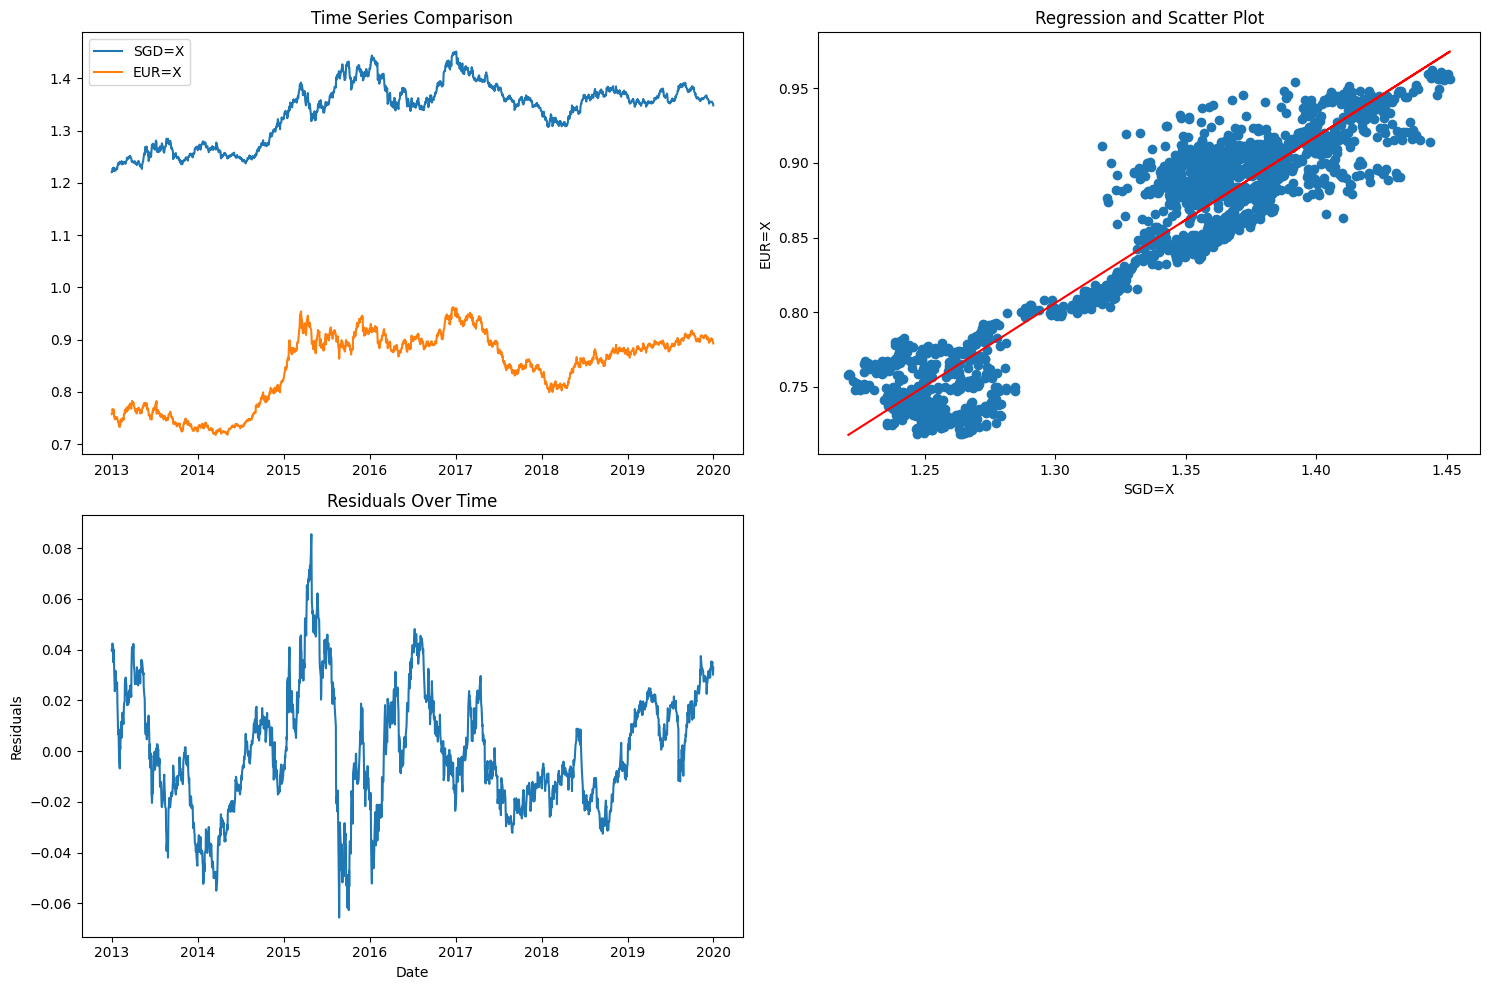

[*********************100%***********************]  2 of 2 completed

ADF Statistic: -3.436066
p-value: 0.009789
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):
Trace Statistics: [17.6988105   2.64138971]
Critical Values: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

--------------------------------------------------

Pair 1 (SGD=X and EUR=X):
Trace Statistic: 17.698810503955837
Eigen Statistic: 15.057420789257662

--------------------------------------------------

Cointegration Assessment: Testing for Zero Cointegrating Relationships (Null Hypothesis)



In [9]:
def perform_regression(data1, data2):
    slope, intercept, r_value, p_value, std_err = linregress(data1.values[:, 0], data2.values[:, 0])
    residuals = data2 - slope * data1 - intercept
    return residuals, slope, intercept, r_value, p_value, std_err
 
def test_stationarity(data):
    result = adfuller(data['price'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
 
def create_dashboard(data1, data2, residuals, slope, intercept, label1, label2):
    plt.figure(figsize=(15, 10))
 
    # Time Series Plot
    plt.subplot(2, 2, 1)
    plt.plot(data1, label=label1)
    plt.plot(data2, label=label2)
    plt.title('Time Series Comparison')
    plt.legend()
 
    # Scatter Plot with Regression Line
    plt.subplot(2, 2, 2)
    plt.scatter(data1.values, data2.values)
    plt.plot(data1, slope * data1 + intercept, color='red')  # regression line
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title('Regression and Scatter Plot')
 
    # Residuals Plot
    plt.subplot(2, 2, 3)
    plt.plot(residuals)
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
 
    plt.tight_layout()
    plt.show()

def Johansen(begin, stop, stock_list):
    data = yf.download(stock_list, start=begin, end=stop)['Adj Close']

    # Perform the Johansen Cointegration Test with a specified number of zero
    specified_number = 0  # Testing for zero cointegrating relationships
    coint_test_result = coint_johansen(data, specified_number, 1)

    # Extract the trace statistics and eigen statistics
    trace_stats = coint_test_result.lr1
    eigen_stats = coint_test_result.lr2

    # Print the test results
    print("Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):")
    print(f"Trace Statistics: {coint_test_result.lr1}")
    print(f"Critical Values: {coint_test_result.cvt}")

    # Define stock pairs
    stock_pairs = [('SGD=X', 'EUR=X')]

    # Separate the output sections
    print("\n" + "-" * 50 + "\n")

    # Interpret the results for each pair
    for i, (stock1, stock2) in enumerate(stock_pairs):
        trace_statistic = trace_stats[i]
        eigen_statistic = eigen_stats[i]
        print(f"Pair {i + 1} ({stock1} and {stock2}):")
        print(f"Trace Statistic: {trace_statistic}")
        print(f"Eigen Statistic: {eigen_statistic}")
        print("\n" + "-" * 50 + "\n")

    # Determine cointegration based on critical values or other criteria
    # Add your cointegration assessment logic here
    print("Cointegration Assessment: Testing for Zero Cointegrating Relationships (Null Hypothesis)\n")
 
if __name__ == '__main__':
    start_date = datetime.datetime(2013, 1, 1)
    end_date = datetime.datetime(2020, 1, 1)
 
    stock1 = 'SGD=X'
    stock2 = 'EUR=X'
 
    data1 = download_data(stock1, start_date, end_date)
    data2 = download_data(stock2, start_date, end_date)
 
    if not data1.empty and not data2.empty:
        residuals, slope, intercept, r_value, p_value, std_err = perform_regression(data1, data2)
        print(f"Regression R-squared: {r_value**2}, p-value: {p_value}, Standard Error: {std_err}")
 
        create_dashboard(data1['price'], data2['price'], residuals, slope, intercept, stock1, stock2)
        test_stationarity(residuals)
        Johansen(start_date, end_date, [stock1, stock2])

0.7448449158540054


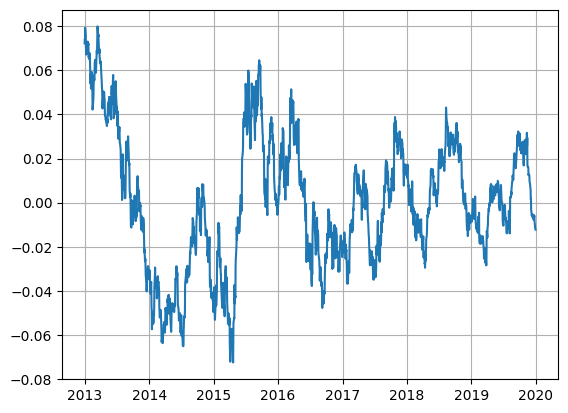

In [45]:
start_date = datetime.datetime(2013,1,1)
end_date = datetime.datetime(2019,12,31)
AUD = download_data('AUD=X', start_date, end_date)
NZD = download_data('NZD=X', start_date, end_date)
AUD['logprice'] = AUD['price'].apply(np.log)
NZD['logprice'] = NZD['price'].apply(np.log)
slope, intercept, r_value, p_value, std_err = linregress(AUD.values[:, 1], NZD.values[:, 1])
residuals = NZD['logprice'] - slope * AUD['logprice'] - intercept
print(slope)     
plt.plot(residuals)
plt.grid()
plt.show()          